<a href="https://colab.research.google.com/gist/daryarudenko/456c0713d117daeffe5b5821d6a10496/time_series_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. ПОДГОТОВКА ДАННЫХ ДЛЯ ВРЕМЕННОГО РЯДА

In [ ]:
#Создаем таблицу для временного ряда
#Извлекаем только дату и выручку для построения графика продаж

onl_sales = onl[['InvoiceDate', 'Revenue']].copy()
onl_sales.columns = ['date', 'sales']
display(onl_sales)

,date,sales
0,2009-12-01 07:45:00,83.40
1,2009-12-01 07:45:00,81.00
2,2009-12-01 07:45:00,81.00
3,2009-12-01 07:45:00,100.80
4,2009-12-01 07:45:00,30.00
...,...,...
1067366,2011-12-09 12:50:00,12.60
1067367,2011-12-09 12:50:00,16.60
1067368,2011-12-09 12:50:00,16.60
1067369,2011-12-09 12:50:00,14.85


In [ ]:
#Приводим дату к формату без времени (только дата)
onl_sales['date'] = pd.to_datetime(onl_sales['date'].dt.date)

#Агрегируем продажи по дням (суммируем все продажи за день)
onl_sales = onl_sales.groupby('date')['sales'].sum().reset_index()
print(len(onl_sales))

#Удаляем возможные дубликаты и устанавливаем дату как индекс
onl_sales=onl_sales.drop_duplicates()
onl_sales.set_index('date', inplace=True)
display(onl_sales.head(5))

604


,sales
date,
2009-12-01,43894.87
2009-12-02,52762.06
2009-12-03,67413.62
2009-12-04,33913.81
2009-12-05,9803.05


In [ ]:
#Агрегация по месяцам (выбор месяца обоснован бизнес-циклами и предположительной сезонностью)
onl_monthly = onl_sales.resample('M').sum()
display(onl_monthly.head(5))


/tmp/ipython-input-651739153.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



,sales
date,
2009-12-31,683504.010
2010-01-31,555802.672
2010-02-28,504558.956
2010-03-31,696978.471
2010-04-30,591982.002


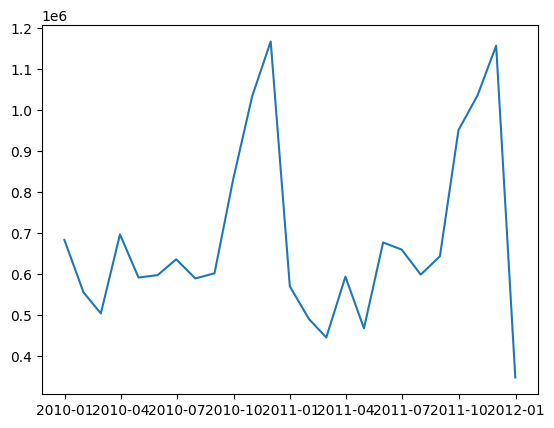

In [ ]:
#Визуализируем месячные продажи
plt.plot(onl_monthly.index, onl_monthly.values)
plt.show()


2. ПРОВЕРКА ВРЕМЕННОГО РЯДА НА СТАЦИОНАРНОСТЬ

ТЕСТ ДИКИ-ФУЛЛЕРА (ADF test):
- H0: ряд НЕ является стационарным (имеет единичный корень)
- H1: ряд является стационарным
- Если p-value < 0.05 → отвергаем H0 → ряд стационарен

In [ ]:
from statsmodels.tsa.stattools import adfuller
p_value = adfuller(onl_monthly.values)[1]
print(p_value)

#Ряд стационарный, p-value<0.05

0.025164589064841897


3. АНАЛИЗ АВТОКОРРЕЛЯЦИИ (ACF/PACF)

ACF (Autocorrelation Function) - функция автокорреляции:
   Показывает корреляцию между рядом и его лаговыми значениями.
   Помогает определить порядок MA.

PACF (Partial Autocorrelation Function) - частная автокорреляция:
   Показывает корреляцию между рядом и его лаговыми значениями
   после исключения влияния промежуточных лагов.
   Помогает определить порядок AR.

Text(0.5, 1.0, 'PACF')

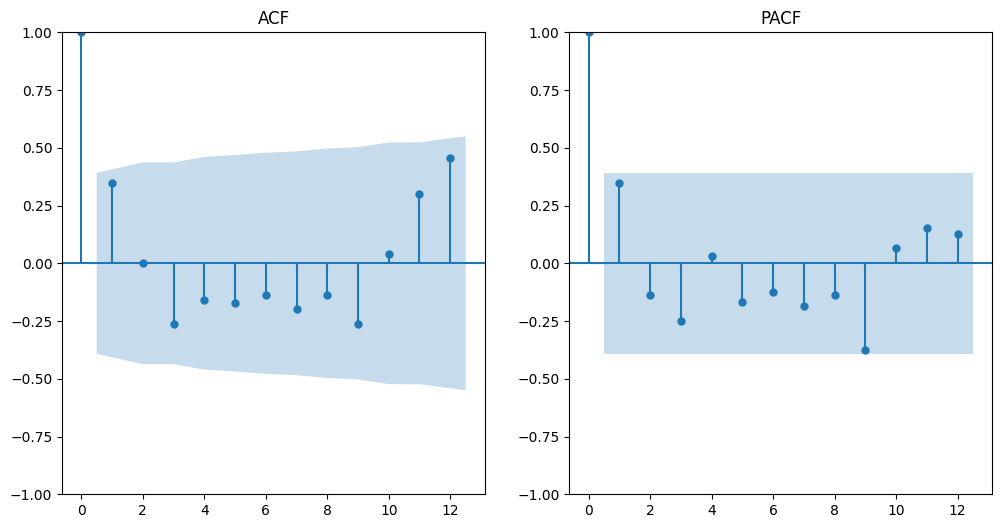

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#График автокорреляции (ACF)
plt.figure(figsize=(12,6))
plt.subplot(121) # чтобы вывести начала 1 график потом 2
plot_acf(onl_monthly, ax=plt.gca(), lags = 12)
plt.title('ACF')

#График частной автокорреляции (PACF)
plt.subplot(122)
plot_pacf(onl_monthly, ax=plt.gca(), lags = 12)
plt.title('PACF')


#MA=0, на графике ACF нет значимых выбросов (все внутри синей зоны). AR=0

4. ПОСТРОЕНИЕ БАЗОВОЙ МОДЕЛИ ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

traine_size = int(len(onl)*0.7) # 30% выделили в тестовую группу
train = onl_monthly[:traine_size] #разделили наш датасет
test = onl_monthly[traine_size:]
model1 = ARIMA(train, order = (0,0,0)) #ar=0, 0-не было дифференцирования,0-ma
model_fit1 = model1.fit()

print(model_fit1.summary())

#Высокий AIC подтверждает то, что данная модель не подходит для данных, есть сезонность

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   25
Model:                          ARIMA   Log Likelihood                -370.707
Date:                Tue, 23 Dec 2025   AIC                            745.414
Time:                        13:11:51   BIC                            747.852
Sample:                    12-31-2009   HQIC                           746.090
                         - 12-31-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.852e+05   1.08e+06      0.636      0.525   -1.43e+06     2.8e+06
sigma2      1.159e+12   4.83e+11      2.402      0.016    2.13e+11     2.1e+12
Ljung-Box (L1) (Q):                   3.39   Jarque-

5. ПОСТРОЕНИЕ МОДЕЛИ SARIMA С СЕЗОННОСТЬЮ

In [ ]:
#Модель с сезонным AR компонентом
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(train,
                      order=(0, 0, 0),
                      seasonal_order=(1, 0, 0, 12))

model_sarima_fit = model_sarima.fit(disp=False)

print(model_sarima_fit.summary())

#модель SARIMA учитывает выраженную годовую сезонность временного ряда, AIC значительно меньше

                                SARIMAX Results                                 
Dep. Variable:                    sales   No. Observations:                   17
Model:             SARIMAX(1, 0, 0, 12)   Log Likelihood                -292.732
Date:                  Tue, 23 Dec 2025   AIC                            589.464
Time:                          13:15:01   BIC                            591.131
Sample:                      12-31-2009   HQIC                           589.630
                           - 04-30-2011                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9996      0.000   2936.515      0.000       0.999       1.000
sigma2      3.865e+08   8.56e-16   4.51e+23      0.000    3.86e+08    3.86e+08
Ljung-Box (L1) (Q):                 

In [ ]:
#Модель с сезонными AR и MA компонентами
model_sarima2 = SARIMAX(train,
                      order=(0, 0, 0),
                      seasonal_order=(1, 0, 1, 12))

model_sarima_fit2 = model_sarima2.fit(disp=False)

print(model_sarima_fit2.summary())

#Cамый низкий aic, низкая гетероскедастичность

                                 SARIMAX Results                                  
Dep. Variable:                      sales   No. Observations:                   17
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                -244.710
Date:                    Tue, 23 Dec 2025   AIC                            495.419
Time:                            13:14:40   BIC                            497.919
Sample:                        12-31-2009   HQIC                           495.668
                             - 04-30-2011                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9673     98.079      0.010      0.992    -191.264     193.198
ma.S.L12   -3.966e-05   1523.708   -2.6e-08      1.000   -2986.412    2986.412
sigma2      3.336e+1

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



6. ОЦЕНКА КАЧЕСТВА ПРОГНОЗА

In [ ]:
train_size = int(len(onl_monthly) * 0.7)
train = onl_monthly.iloc[:train_size]
test = onl_monthly.iloc[train_size:]

#Прогнозирование на период тестовой выборки
forecast = model_sarima_fit2.forecast(steps=len(test))

#Расчет метрик качества
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test.values - forecast.values) / test.values)) * 100

print(mae)
print(mape)

#Модель ошибается в среднем на 38.8%, <50% - удовлетворительная точность прогноза

81205.53245949041
38.77424508744365


7. АНАЛИЗ ОСТАТКОВ МОДЕЛИ

Остатки (residuals) - разница между фактическими и прогнозными значениями.
Хорошая модель должна иметь остатки, близкие к белому шуму:
   1. Нормальное распределение
   2. Отсутствие автокорреляции
   3. Постоянная дисперсия (гомоскедастичность)

     lb_stat  lb_pvalue
1   7.033980   0.007998
2   8.510843   0.014187
3   8.557288   0.035795
4   8.890435   0.063897
5  11.021399   0.050957
6  11.956001   0.062958
7  12.240883   0.092910
8  12.333944   0.136914


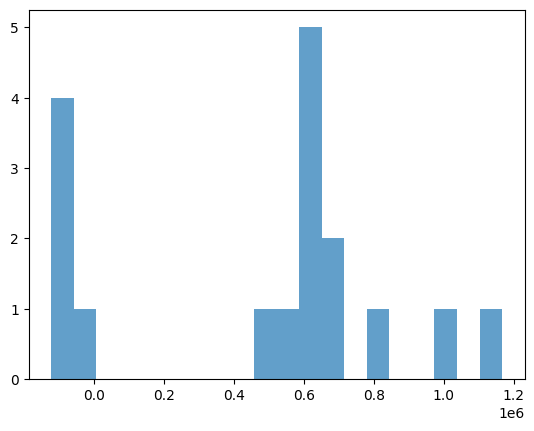

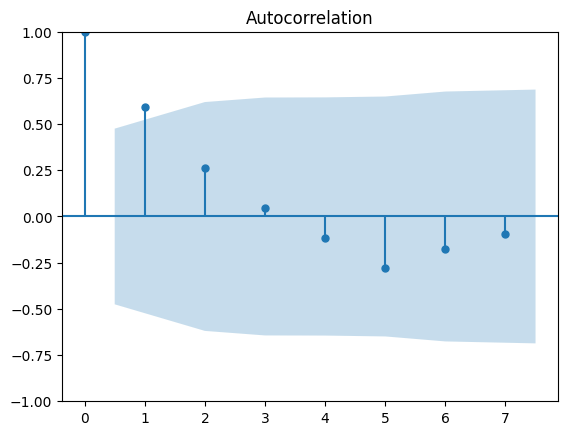

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

#Получение остатков модели
residuals = model_sarima_fit.resid.dropna()

#Тест Льюинга-Бокса на автокорреляцию
# H0: остатки являются белым шумом (нет автокорреляции). H1: остатки имеют автокорреляцию
lb_test = acorr_ljungbox(residuals, lags=min(10, len(residuals)//2))
print(lb_test)

#Гистограмма распределения остатков
plt.hist(residuals, bins=20, alpha=0.7)
plt.show()

#ACF остатков
plot_acf(residuals, lags=min(20, len(residuals)//2 - 1))
plt.show()

#Последний лаг - p-value>0.05 -> автокорреляции нет. Гистограмма близка к нормальному распределению. На ACF значимых лагов нет.
#Модель адекватна и может использоваться для прогнозирования

8. ПРОГНОЗИРОВАНИЕ БУДУЩИХ ПРОДАЖ

In [ ]:
#Обучение финальной модели на всех доступных данных
final_model = SARIMAX(onl_monthly,
                     order=(0,0,0),
                     seasonal_order=(1,0,1,12))
final_model_fit = final_model.fit(disp=False)

#Количество шагов прогноза (10 месяцев вперед)
future_step = 10
future_forecast = final_model_fit.forecast(steps=future_step)

#Генерация дат для прогноза (последний день месяца + 1 месяц)
last_date = onl_monthly.index[-1]
future_dates = pd.date_range(start = last_date + pd.Timedelta(days=30),
                             periods = future_step, freq = 'M')

for date, value in zip(future_dates, future_forecast):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.2f}")

2012-01-31: 465533.51
2012-02-29: 423041.90
2012-03-31: 562011.98
2012-04-30: 440744.46
2012-05-31: 651660.09
2012-06-30: 632035.84
2012-07-31: 572867.99
2012-08-31: 617753.65
2012-09-30: 915182.14
2012-10-31: 989781.55


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/tmp/ipython-input-2755429004.py:10: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



9. ВИЗУАЛИЗАЦИЯ ИСТОРИЧЕСКИХ ДАННЫХ И ПРОГНОЗА

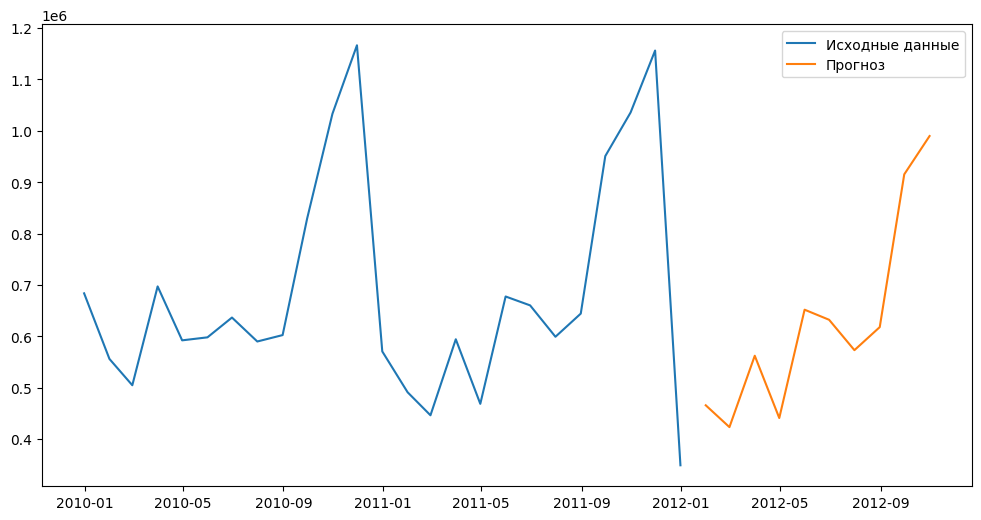

In [ ]:
#Cтроим график с прогнозом
plt.figure(figsize=(12,6))
plt.plot(onl_monthly.index, onl_monthly.values, label='Исходные данные')
plt.plot(future_dates, future_forecast, label='Прогноз')
plt.legend()
plt.show()

ВЫВОДЫ ПО ПРОГНОЗУ:

• Прогноз отражает годовую сезонность (пики в ноябре-декабре)

• Доверительный интервал расширяется с увеличением горизонта прогноза

• Модель может использоваться для краткосрочного планирования (до 6 месяцев)

БИЗНЕС-ВЫВОДЫ:
   1. Продажи имеют ярко выраженную сезонность с пиком в ноябре-декабре
   2. Рекомендуется увеличивать запасы и персонал в предпраздничный период
   3. Прогноз позволяет планировать закупки и маркетинговые кампании